<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Building Advanced Transformers**

**Estimated time needed:  30 minutes**  

In this lab, you will implement and experiment with advanced Transformer models using Keras. 

**Learning objectives:** 

By the end of this lab, you will: 

- Implement advanced Transformer models using Keras. 

- Apply Transformers to real-world sequential data tasks. 

- Build, train, and evaluate Transformer models. 


## Step-by-Step Instructions: 

### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [1]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

2024-11-21 17:41:12.343371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 17:41:12.346348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 17:41:12.367785: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 17:41:12.401022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732210872.437353   12420 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732210872.45

####  Setup the Environment to generate synthetic stock price data


In [3]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")


Synthetic stock_prices.csv created and loaded.


In [4]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [5]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [6]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


### Step 4: Implement Encoder Layer 

Define the Encoder layer. 


In [7]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



In the above code: 

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture. 

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


### Step 5: Implement Transformer encoder 

Define the Transformer Encoder. 


In [8]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

2024-11-21 17:41:16.442713: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(1, 100, 128)


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [9]:
# Define the necessary parameters 

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [10]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 14.6821
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - loss: 0.2079
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - loss: 0.1511
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - loss: 0.1540
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - loss: 0.1367
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 289ms/step - loss: 0.1091
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - loss: 0.1199
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - loss: 0.1389
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - loss: 0.1050
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - loss: 0.1099
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - loss: 0.0933
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - loss: 0.0729
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - loss: 0.0693
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 265ms/step - loss: 0.1055
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s

In the above code: 

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 


### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step


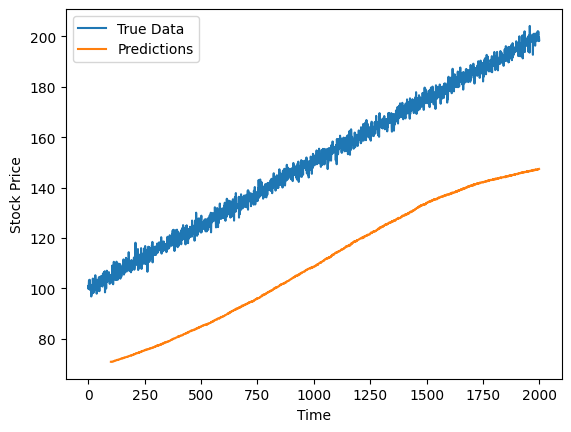

In [11]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(scaler.inverse_transform(data), label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

 

In the above code: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


## Practice Exercises: 

 ### Exercise 1: Add dropout to the Transformer model 

 **Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - loss: 4.2851
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - loss: 0.9944
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - loss: 0.4347
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - loss: 0.1749
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - loss: 0.0868
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - loss: 0.0682
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - loss: 0.0543
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - loss: 0.0461
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 265ms/step - loss: 0.0486
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - loss: 0.0387
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - loss: 0.0338
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - loss: 0.0397
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - loss: 0.0311
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - loss: 0.0258
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 

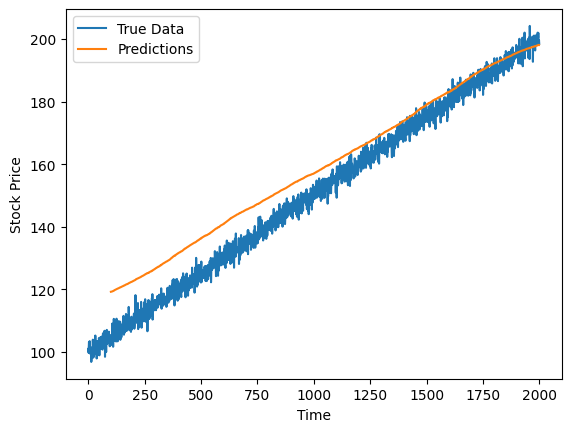

In [12]:
## Write your code here.
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary()

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Loss: {loss}')

# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 
# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(scaler.inverse_transform(data), label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

<details><summary>Click here to view the solution.</summary>

```
from tensorflow.keras.layers import Dropout 

  

# Add a dropout layer after the Flatten layer 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout) 

  

# Build the model 

model = tf.keras.Model(inputs, outputs) 

  

# Compile the model 

model.compile(optimizer='adam', loss='mse') 

  

# Train the model 

model.fit(X, Y, epochs=20, batch_size=32) 

  

# Evaluate the model 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 

```
</details>


### Exercise 2: Experiment with different batch sizes 

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - loss: 0.0258
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - loss: 0.0258
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - loss: 0.0220
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - loss: 0.0270
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - loss: 0.0225
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - loss: 0.0161
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - loss: 0.0245
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - loss: 0.0166
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - loss: 0.0156
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 913s 8s/step - loss: 0.0142
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - loss: 0.0157
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 212ms/step - loss: 0.0127
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - loss: 0.0080
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - loss: 0.0149
Epoch 15/20
119/1

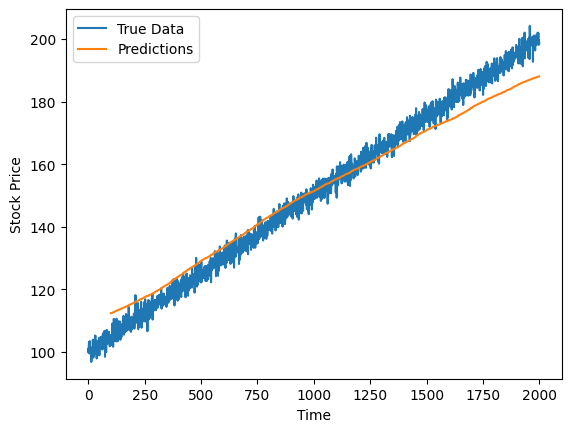

In [13]:
# Write your code here.
# Train the model
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Loss: {loss}')

# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 
# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(scaler.inverse_transform(data), label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 494ms/step - loss: 0.0059
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - loss: 0.0030
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 492ms/step - loss: 0.0026
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - loss: 0.0026
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - loss: 0.0028
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - loss: 0.0023
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 463ms/step - loss: 0.0019
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - loss: 0.0018
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - loss: 0.0020
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - loss: 0.0020
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - loss: 0.0022
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 555ms/step - loss: 0.0020
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step - loss: 0.0019
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - loss: 0.0024
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 

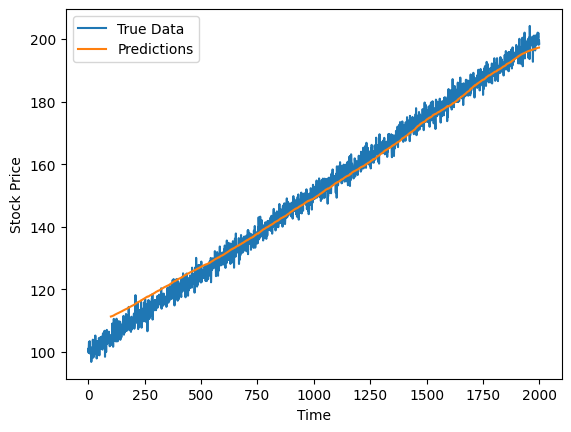

In [14]:
# Write your code here.
# Train the model
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Loss: {loss}')

# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 
# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(scaler.inverse_transform(data), label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

<details><summary>Click here to view the solution.</summary>

```
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

```
</details>


### Exercise 3: Use a different activation function 

 **Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 317ms/step - loss: 0.0659
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - loss: 0.0049
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - loss: 0.0025
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - loss: 0.0047
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - loss: 0.0025
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - loss: 0.0033
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - loss: 0.0025
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - loss: 0.0026
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - loss: 0.0046
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - loss: 0.0018
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - loss: 0.0017
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - loss: 0.0034
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.0021
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - loss: 0.0015
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 

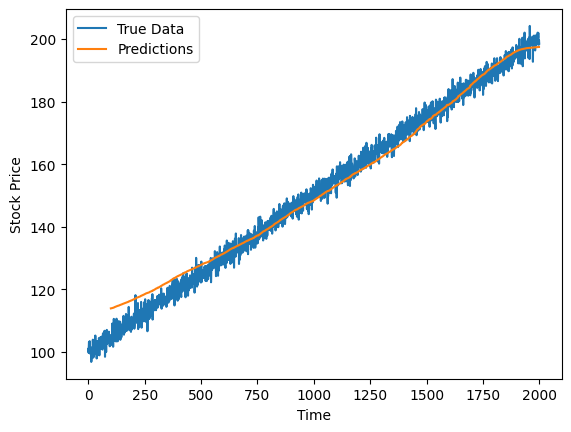

In [15]:
## Write your code here.
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 
# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(scaler.inverse_transform(data), label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

<details><summary>Click here to view the solution.</summary>

```
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

```
</details>


## Conclusion
Congratulations on completing this lab! In this lab, you have built an advanced Transformer model using Keras and applied it to a time series forecasting task. You have learned how to define and implement multi-head self-attention, Transformer blocks, encoder layers, and integrate them into a complete Transformer model. By experimenting with different configurations and training the model, you can further improve its performance and apply it to various sequential data tasks. 


Copyright © IBM Corporation. All rights reserved.
